In [2]:
#import VOC tensorflow dataset as an example

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (binary_crossentropy, sparse_categorical_crossentropy)


from absl import app, flags, logging
import os
import shutil

ds, ds_info = tfds.load('voc', with_info=True)
ds_train = ds['train']
ds_test = ds['test']

In [4]:
def draw_boxes(data, v_boxes, labels, class_labels):
    pyplot.imshow(data)
    ax = pyplot.gca()
    h = tf.dtypes.cast(tf.shape(img)[1], tf.float32)
    w = tf.dtypes.cast(tf.shape(img)[0], tf.float32)
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box[0]*w, box[1]*h, box[2]*w, box[3]*h
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        index = tf.get_static_value(labels[i])
        label = class_labels[index]
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()

In [5]:
# from https://keras.io/examples/vision/retinanet/
# from VOC tfds
def read_class_names(class_file_name):
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names
class_labels = read_class_names("/home/jupyter/moles-detection/voc.names")
class_labels

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

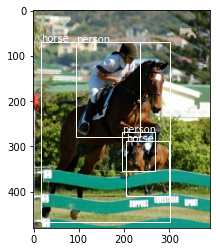

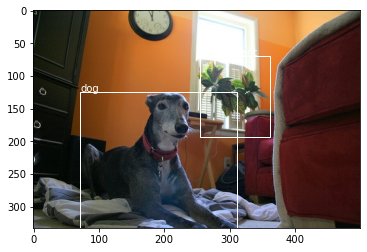

In [6]:
voc_iter = iter(ds_train)
val = next(voc_iter)
img = val['image']
img_info = val['objects']
box = img_info.get('bbox')
labels = img_info.get('label')
draw_boxes(img, box, labels, class_labels)

voc_iter = iter(ds_test)
val = next(voc_iter)
img = val['image']
img_info = val['objects']
box = img_info.get('bbox')
labels = img_info.get('label')
draw_boxes(img, box, labels, class_labels)

In [7]:
# common
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)
    
# convolutional block
def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True, activate_type='leaky'):
    if downsample:
        input_layer = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'
    conv = tf.keras.layers.Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], 
                                  strides=strides, padding=padding, use_bias=not bn, 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  bias_initializer=tf.constant_initializer(value = 0.))(input_layer)

    if bn: conv = BatchNormalization()(conv)
    if activate == True:
        if activate_type == "leaky":
            conv = tf.nn.leaky_relu(conv, alpha=0.1)
        elif activate_type == "mish":
            conv = mish(conv)
    return conv

# miss loss function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# residual block
def residual_block(input_layer, input_channel, filter_num1, filter_num2, activate_type='leaky'):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1), activate_type=activate_type)
    conv = convolutional(conv, filters_shape=(3, 3, filter_num1,   filter_num2), activate_type=activate_type)
    residual_output = short_cut + conv
    return residual_output

def route_group(input_layer, groups, group_id):
    convs = tf.split(input_layer, num_or_size_splits=groups, axis=-1)
    return convs[group_id]

# image upsampling
def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='bilinear')

In [8]:
#utils
import cv2
import random
import colorsys
import numpy as np
import tensorflow as tf

def load_freeze_layer(model='yolov4', tiny=False):
    freeze_layouts = ['conv2d_93', 'conv2d_101', 'conv2d_109']
    return freeze_layouts

def load_weights(model, weights_file, model_name='yolov4', is_tiny=False):
    layer_size = 110
    output_pos = [93, 101, 109]
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    
    j = 0
    for i in range(layer_size):
        conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
        bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'

        conv_layer = model.get_layer(conv_layer_name)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]

        if i not in output_pos:
            # darknet weights: [beta, gamma, mean, variance]
            bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
            # tf weights: [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            bn_layer = model.get_layer(bn_layer_name)
            j += 1
        else:
            conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

        if i not in output_pos:
            conv_layer.set_weights([conv_weights])
            bn_layer.set_weights(bn_weights)
        else:
            conv_layer.set_weights([conv_weights, conv_bias])
    wf.close()

def get_anchors(anchors_path):
    anchors = np.array(anchors_path)
    return anchors.reshape(3, 3, 2)

def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

def bbox_iou(bboxes1, bboxes2):
    """
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = tf.concat(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = tf.concat(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = tf.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = tf.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = tf.math.divide_no_nan(inter_area, union_area)

    return iou


def bbox_giou(bboxes1, bboxes2):
    """
    Generalized IoU
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = tf.concat(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = tf.concat(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = tf.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = tf.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = tf.math.divide_no_nan(inter_area, union_area)

    enclose_left_up = tf.minimum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    enclose_right_down = tf.maximum(
        bboxes1_coor[..., 2:], bboxes2_coor[..., 2:]
    )

    enclose_section = enclose_right_down - enclose_left_up
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - tf.math.divide_no_nan(enclose_area - union_area, enclose_area)

    return giou

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)
    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bbox_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)
            
def unfreeze_all(model, frozen=False):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            unfreeze_all(l, frozen)

def process_image(ele): 
    return ele['image']
def process_bbox(ele): 
    return ele['objects'].get('bbox')    
def process_label(ele): 
    return ele['objects'].get('label')
def create_bbox(v_boxes, labels, image):
    bboxes = []
    h = tf.dtypes.cast(tf.shape(image)[1], tf.float32)
    w = tf.dtypes.cast(tf.shape(image)[0], tf.float32)
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box[0]*w, box[1]*h, box[2]*w, box[3]*h
        label = tf.dtypes.cast(labels[i], tf.float32)
        new_box = [y1, x1, y2, x2]
        new_box.append(label)
        bboxes.append(new_box)
#     bboxes = tf.reshape(bboxes, [-1])
    return bboxes

In [9]:
# CSPdarknet53 as backbone
def cspdarknet53(x):
    x = convolutional(x, (3, 3,  3,  32), activate_type="mish")
    x = convolutional(x, (3, 3, 32,  64), downsample=True, activate_type="mish")

    route = x
    route = convolutional(route, (1, 1, 64, 64), activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")
    x = residual_block(x,  64,  32, 64, activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")

    x = tf.concat([x, route], axis=-1)
    x = convolutional(x, (1, 1, 128, 64), activate_type="mish")
    x = convolutional(x, (3, 3, 64, 128), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 128, 64), activate_type="mish")
    x = convolutional(x, (1, 1, 128, 64), activate_type="mish")
    for i in range(2):
        x = residual_block(x, 64,  64, 64, activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 128, 128), activate_type="mish")
    x = convolutional(x, (3, 3, 128, 256), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 256, 128), activate_type="mish")
    x = convolutional(x, (1, 1, 256, 128), activate_type="mish")
    for i in range(8):
        x = residual_block(x, 128, 128, 128, activate_type="mish")
    x = convolutional(x, (1, 1, 128, 128), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 256, 256), activate_type="mish")
    route_1 = x
    x = convolutional(x, (3, 3, 256, 512), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 512, 256), activate_type="mish")
    x = convolutional(x, (1, 1, 512, 256), activate_type="mish")
    for i in range(8):
        x = residual_block(x, 256, 256, 256, activate_type="mish")
    x = convolutional(x, (1, 1, 256, 256), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 512, 512), activate_type="mish")
    route_2 = x
    x = convolutional(x, (3, 3, 512, 1024), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 1024, 512), activate_type="mish")
    x = convolutional(x, (1, 1, 1024, 512), activate_type="mish")
    for i in range(4):
        x = residual_block(x, 512, 512, 512, activate_type="mish")
    x = convolutional(x, (1, 1, 512, 512), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 1024, 1024), activate_type="mish")
    x = convolutional(x, (1, 1, 1024, 512))
    x = convolutional(x, (3, 3, 512, 1024))
    x = convolutional(x, (1, 1, 1024, 512))

    x = tf.concat([tf.nn.max_pool(x, ksize=13, padding='SAME', strides=1), tf.nn.max_pool(x, ksize=9, padding='SAME', strides=1)
                            , tf.nn.max_pool(x, ksize=5, padding='SAME', strides=1), x], axis=-1)
    x = convolutional(x, (1, 1, 2048, 512))
    x = convolutional(x, (3, 3, 512, 1024))
    x = convolutional(x, (1, 1, 1024, 512))

    return route_1, route_2, x

In [10]:
def YOLOv4(input_layer, NUM_CLASS):
    route_1, route_2, conv = cspdarknet53(input_layer)
    route = conv
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = upsample(conv)
    route_2 = convolutional(route_2, (1, 1, 512, 256))
    conv = tf.concat([route_2, conv], axis=-1)

    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)
    route_1 = convolutional(route_1, (1, 1, 256, 128))
    conv = tf.concat([route_1, conv], axis=-1)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))

    route_1 = conv
    conv = convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = convolutional(conv, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(route_1, (3, 3, 128, 256), downsample=True)
    conv = tf.concat([conv, route_2], axis=-1)

    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = convolutional(conv, (1, 1, 512, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(route_2, (3, 3, 256, 512), downsample=True)
    conv = tf.concat([conv, route], axis=-1)

    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))

    conv = convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = convolutional(conv, (1, 1, 1024, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

def decode_train(conv_output, output_size, NUM_CLASS, STRIDES, ANCHORS, i=0, XYSCALE=[1, 1, 1]):
    conv_output = tf.reshape(conv_output,
                             (tf.shape(conv_output)[0], output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS),
                                                                          axis=-1)

    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [tf.shape(conv_output)[0], 1, 1, 3, 1])

    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = ((tf.sigmoid(conv_raw_dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * \
              STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i])
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)
    
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def compute_loss(pred, conv, label, bboxes, STRIDES, NUM_CLASS, IOU_LOSS_THRESH, i=0):
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1- giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

In [11]:
# parameters
SIZE = 416
NUM_CLASS = 20

ANCHORS              = [12,16, 19,36, 40,28, 36,75, 76,55, 72,146, 142,110, 192,243, 459,401]
STRIDES              = [8, 16, 32]
XYSCALE              = [1.2, 1.1, 1.05]
ANCHOR_PER_SCALE     = 3
IOU_LOSS_THRESH      = 0.5
DATA_AUG = False
# Train options
BATCH_SIZE          = 2
INPUT_SIZE          = 416
LR_INIT             = 1e-3
LR_END              = 5e-5 #originally 1e-6
WARMUP_EPOCHS       = 2
FISRT_STAGE_EPOCHS    = 20
SECOND_STAGE_EPOCHS   = 30

CLASSES = {0: 'aeroplane', 
           1: 'bicycle',
           2: 'bird',
           3: 'boat',
           4: 'bottle',
           5: 'bus',
           6: 'car',
           7: 'cat',
           8: 'chair',
           9: 'cow',
           10: 'diningtable',
           11: 'dog',
           12: 'horse',
           13: 'motorbike',
           14: 'person',
           15: 'pottedplant',
           16: 'sheep',
           17: 'sofa',
           18: 'train',
           19: 'tvmonitor'}

In [12]:
# datset.py
import os
import cv2
import random
import numpy as np
import tensorflow as tf

class Dataset(object):
    """implement Dataset here"""
    NUM_CLASS = 20
    ANCHORS              = [12,16, 19,36, 40,28, 36,75, 76,55, 72,146, 142,110, 192,243, 459,401]
    STRIDES              = [8, 16, 32]
    XYSCALE              = [1.2, 1.1, 1.05]
    ANCHOR_PER_SCALE     = 3
    IOU_LOSS_THRESH      = 0.5
    BATCH_SIZE          = 2
    INPUT_SIZE          = 416
    DATA_AUG            = False #default is True
    LR_INIT             = 1e-3
    LR_END              = 5e-5 # 1e-6 originally
    WARMUP_EPOCHS       = 2
    FISRT_STAGE_EPOCHS    = 20
    SECOND_STAGE_EPOCHS   = 30
    CLASSES = {0: 'aeroplane', 
               1: 'bicycle',
               2: 'bird',
               3: 'boat',
               4: 'bottle',
               5: 'bus',
               6: 'car',
               7: 'cat',
               8: 'chair',
               9: 'cow',
               10: 'diningtable',
               11: 'dog',
               12: 'horse',
               13: 'motorbike',
               14: 'person',
               15: 'pottedplant',
               16: 'sheep',
               17: 'sofa',
               18: 'train',
               19: 'tvmonitor'}
    
    def __init__(self, dataset):
        self.strides = np.array(STRIDES)
        self.anchors = get_anchors(ANCHORS)
        self.input_sizes = INPUT_SIZE
        self.batch_size = BATCH_SIZE
        self.data_aug = DATA_AUG
        self.train_input_sizes = INPUT_SIZE       
        self.classes = CLASSES     
        self.num_classes = NUM_CLASS      
        self.anchor_per_scale = ANCHOR_PER_SCALE
        self.max_bbox_per_scale = 150
        
        self.images = list(dataset.map(process_image).as_numpy_iterator())
        self.bboxes = list(dataset.map(process_bbox).as_numpy_iterator())
        self.labels = list(dataset.map(process_label).as_numpy_iterator())  
        
        self.num_samples = len(dataset)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0

    def __iter__(self):
        return self

    def __next__(self):
        with tf.device("/cpu:0"):
            self.train_input_size = INPUT_SIZE
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros(
                (
                    self.batch_size,
                    self.train_input_size,
                    self.train_input_size,
                    3,
                ),
                dtype=np.float32,
            )

            batch_label_sbbox = np.zeros(
                (
                    self.batch_size,
                    self.train_output_sizes[0],
                    self.train_output_sizes[0],
                    self.anchor_per_scale,
                    5 + self.num_classes,
                ),
                dtype=np.float32,
            )
            
            batch_label_mbbox = np.zeros(
                (
                    self.batch_size,
                    self.train_output_sizes[1],
                    self.train_output_sizes[1],
                    self.anchor_per_scale,
                    5 + self.num_classes,
                ),
                dtype=np.float32,
            )
            batch_label_lbbox = np.zeros(
                (
                    self.batch_size,
                    self.train_output_sizes[2],
                    self.train_output_sizes[2],
                    self.anchor_per_scale,
                    5 + self.num_classes,
                ),
                dtype=np.float32,
            )

            batch_sbboxes = np.zeros(
                (self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32
            )
            batch_mbboxes = np.zeros(
                (self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32
            )
            batch_lbboxes = np.zeros(
                (self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32
            )

            num = 0
            images = self.images  
            bboxes = self.bboxes
            labels = self.labels
            
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples:
                        index -= self.num_samples 
                        
                    image = images[i]
                    bbox = create_bbox(bboxes[i], labels[i], images[i])
                    image, bbox = image_preprocess(
                        np.copy(image), [self.train_input_size, 
                                         self.train_input_size], np.copy(bbox))
                    (label_sbbox, label_mbbox, label_lbbox, sbboxes,
                     mbboxes, lbboxes) = self.preprocess_true_boxes(bbox)
                    batch_image[num, :, :, :] = image
                
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target = batch_label_mbbox, batch_mbboxes
                batch_larger_target = batch_label_lbbox, batch_lbboxes

                return (
                    batch_image,
                    (
                        batch_smaller_target,
                        batch_medium_target,
                        batch_larger_target,
                    ),
                )
            else:
                self.batch_count = 0
#                 np.random.shuffle(self.annotations)
                raise StopIteration

    def preprocess_true_boxes(self, bboxes):
        label = [
            np.zeros(
                (
                    self.train_output_sizes[i],
                    self.train_output_sizes[i],
                    self.anchor_per_scale,
                    5 + self.num_classes,
                )
            )
            for i in range(3)
        ]
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = int(bbox[4])
            onehot = np.zeros(self.num_classes, dtype=np.float)
            onehot[bbox_class_ind] = 1.0
            uniform_distribution = np.full(
                self.num_classes, 1.0 / self.num_classes
            )
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate(
                [
                    (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
                    bbox_coor[2:] - bbox_coor[:2],
                ],
                axis=-1,
            )
            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = bbox_iou(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot

                bbox_ind = int(
                    bbox_count[best_detect] % self.max_bbox_per_scale
                )
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1
        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs

In [13]:
trainset = Dataset(ds_train)
input_layer = Input([SIZE, SIZE, 3])
feature_maps = YOLOv4(input_layer, NUM_CLASS)

In [14]:
feature_maps

[<tf.Tensor 'conv2d_93/BiasAdd:0' shape=(None, 52, 52, 75) dtype=float32>,
 <tf.Tensor 'conv2d_101/BiasAdd:0' shape=(None, 26, 26, 75) dtype=float32>,
 <tf.Tensor 'conv2d_109/BiasAdd:0' shape=(None, 13, 13, 75) dtype=float32>]

In [15]:
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    if i == 0:
        bbox_tensor = decode_train(fm, SIZE // 8, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    elif i == 1:
        bbox_tensor = decode_train(fm, SIZE // 16, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    else:
        bbox_tensor = decode_train(fm, SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    bbox_tensors.append(fm) 
    bbox_tensors.append(bbox_tensor) #confidence map

bbox_tensors

[<tf.Tensor 'conv2d_93/BiasAdd:0' shape=(None, 52, 52, 75) dtype=float32>,
 <tf.Tensor 'concat_11:0' shape=(None, 52, 52, 3, 25) dtype=float32>,
 <tf.Tensor 'conv2d_101/BiasAdd:0' shape=(None, 26, 26, 75) dtype=float32>,
 <tf.Tensor 'concat_13:0' shape=(None, 26, 26, 3, 25) dtype=float32>,
 <tf.Tensor 'conv2d_109/BiasAdd:0' shape=(None, 13, 13, 75) dtype=float32>,
 <tf.Tensor 'concat_15:0' shape=(None, 13, 13, 3, 25) dtype=float32>]

In [16]:
model = Model(input_layer, bbox_tensors, name='yolov4')
model.summary()

Model: "yolov4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Softplus (TensorFlo [(None, 416, 416, 32 0           batch_normalization[0][0]        
_____________________________________________________________________________________________

In [18]:
steps_per_epoch = round(len(trainset)/4) #len trainset originally
# steps_per_epoch = len(trainset)
first_stage_epochs = FISRT_STAGE_EPOCHS
second_stage_epochs = SECOND_STAGE_EPOCHS
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = WARMUP_EPOCHS * steps_per_epoch
total_steps = (first_stage_epochs + second_stage_epochs) * steps_per_epoch

In [ ]:
optimizer = tf.keras.optimizers.Adam()

logdir = "/home/jupyter/moles-detection/log"

if os.path.exists(logdir): shutil.rmtree(logdir)
writer = tf.summary.create_file_writer(logdir)

freeze_layers = load_freeze_layer(model='yolov4', tiny=False)
isfreeze = False

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = model(image_data, training=True)
        giou_loss = conf_loss = prob_loss = 0

        for i in range(len(freeze_layers)):
            conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
            loss_items = compute_loss(pred, conv, target[i][0], target[i][1], 
                                      STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tf.print("=> STEP %4d/%4d   lr: %.6f   giou_loss: %4.2f   conf_loss: %4.2f   "
                 "prob_loss: %4.2f   total_loss: %4.2f" % (global_steps, total_steps, optimizer.lr.numpy(),
                                                           giou_loss, conf_loss,
                                                           prob_loss, total_loss))
        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:
            lr = global_steps / warmup_steps * LR_INIT
        else:
            lr = LR_END + 0.5 * (LR_INIT - LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi))
            )
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()
        
# def test_step(image_data, target):
#     with tf.GradientTape() as tape:
#         pred_result = model(image_data, training=True)
#         giou_loss = conf_loss = prob_loss = 0

#         # optimizing process
#         for i in range(len(freeze_layers)):
#             conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
#             loss_items = compute_loss(pred, conv, target[i][0], target[i][1], STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
#             giou_loss += loss_items[0]
#             conf_loss += loss_items[1]
#             prob_loss += loss_items[2]

#         total_loss = giou_loss + conf_loss + prob_loss

#         tf.print("=> TEST STEP %4d   giou_loss: %4.2f   conf_loss: %4.2f   "
#                  "prob_loss: %4.2f   total_loss: %4.2f" % (global_steps, giou_loss, conf_loss,
#                                                            prob_loss, total_loss))

for epoch in range(first_stage_epochs + second_stage_epochs):
    if epoch < first_stage_epochs:
        if not isfreeze:
            isfreeze = True
            for name in freeze_layers:
                freeze = model.get_layer(name)
                freeze_all(freeze)
    elif epoch >= first_stage_epochs:
        if isfreeze:
            isfreeze = False
            for name in freeze_layers:
                freeze = model.get_layer(name)
                unfreeze_all(freeze)
    for image_data, target in trainset:
        train_step(image_data, target)
#     for image_data, target in testset:
#         test_step(image_data, target)
    model.save_weights("/home/jupyter/moles-detection")

=> STEP    1/15650   lr: 0.001000   giou_loss: 2.90   conf_loss: 1843.22   prob_loss: 27.27   total_loss: 1873.39
=> STEP    2/15650   lr: 0.000003   giou_loss: 2.90   conf_loss: 2214.93   prob_loss: 28.07   total_loss: 2245.90
=> STEP    3/15650   lr: 0.000005   giou_loss: 2.90   conf_loss: 2179.76   prob_loss: 27.93   total_loss: 2210.58
=> STEP    4/15650   lr: 0.000006   giou_loss: 2.90   conf_loss: 2137.40   prob_loss: 27.84   total_loss: 2168.13
=> STEP    5/15650   lr: 0.000008   giou_loss: 2.90   conf_loss: 2092.19   prob_loss: 27.78   total_loss: 2122.87
=> STEP    6/15650   lr: 0.000010   giou_loss: 2.90   conf_loss: 2044.65   prob_loss: 27.83   total_loss: 2075.38
=> STEP    7/15650   lr: 0.000011   giou_loss: 2.90   conf_loss: 1993.50   prob_loss: 27.66   total_loss: 2024.05
=> STEP    8/15650   lr: 0.000013   giou_loss: 2.90   conf_loss: 1946.32   prob_loss: 27.41   total_loss: 1976.62
=> STEP    9/15650   lr: 0.000014   giou_loss: 2.90   conf_loss: 1903.65   prob_loss: 27